BLG 307 - YAPAY ZEKA SİSTEMLERİ PROJE TESLİMİ:

Adınız: Ali

Soyadınız: Uçma

Okul Numaranız: 2212721007

GitHub Repo Bağlantısı: https://github.com/Alu0320/genetik_optimizasyon

--- Laboratuvar Numune Karışımı Optimizasyonu Başlıyor ---
Gen   0 | En iyi: [70, 30] | Fitness (Skor): 1920.00
Gen  10 | En iyi: [68, 32] | Fitness (Skor): 1932.00
Gen  20 | En iyi: [67, 33] | Fitness (Skor): 1933.50
Gen  30 | En iyi: [67, 33] | Fitness (Skor): 1933.50
Gen  40 | En iyi: [67, 33] | Fitness (Skor): 1933.50
Gen  49 | En iyi: [67, 33] | Fitness (Skor): 1933.50

=== SONUC ===
En iyi karışım: Reaktif A (x1): %67, Reaktif B (x2): %33
Kisitlar sağlaniyor mu?: True
Test Hassasiyeti (Skor): 1933.5
Toplam Karışım Oranı: %100


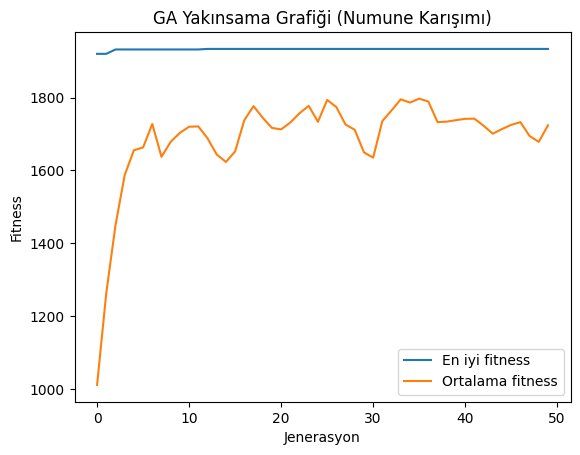

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Tekrarlanabilir sonuçlar için seed ayarı
random.seed(42)
np.random.seed(42)

# --- SENARYO 7: Laboratuvarda Numune Karışımı ---

# Amaç Fonksiyonu: Test hassasiyeti puanı
# y = 3x1 + 2x2 + x1*x2 - 0.5*x2^2
def amac_fonksiyonu(x1, x2):
    return 3*x1 + 2*x2 + (x1 * x2) - 0.5 * (x2**2)

# Kısıt Kontrolü
def kisit_saglanir_mi(x1, x2):
    # Temel aralık kısıtları
    if not (10 <= x1 <= 80): return False
    if not (10 <= x2 <= 80): return False

    # Özel kısıtlar
    if x1 < 25: return False        # x1 >= 25 kısıtı
    if x1 + x2 > 100: return False  # Toplam <= 100 kısıtı

    return True

# Rastgele Birey Üretimi (Kısıtlara uygun)
def rastgele_birey_uret():
    # x1 için minimum 25 (kısıt gereği), maksimum 80
    x1 = random.randint(25, 80)

    # x2 için minimum 10, maksimum ise (100 - x1) veya 80'den küçük olanı
    max_x2 = min(80, 100 - x1)
    # Eğer x1 çok yüksekse ve x2 için yer kalmadıysa alt sınır 10 korunur (döngüde düzeltilir)
    if max_x2 < 10: max_x2 = 10

    x2 = random.randint(10, max_x2)
    return [x1, x2]

# Popülasyon Oluşturma
def populasyon_uret(pop_boyutu):
    return [rastgele_birey_uret() for _ in range(pop_boyutu)]

# Fitness Fonksiyonu (Ceza Yöntemi ile)
def fitness(birey):
    x1, x2 = birey
    skor = amac_fonksiyonu(x1, x2)
    ceza = 0

    # x1 aralık ve alt sınır kısıtı (x1 >= 25 ve x1 <= 80)
    # Problem tanımında x1 [10,80] dense de ek kısıt x1>=25 olduğu için efektif sınır 25'tir.
    if x1 < 25:
        ceza += (25 - x1) * 1000
    if x1 > 80:
        ceza += (x1 - 80) * 1000

    # x2 aralık kısıtı
    if x2 < 10:
        ceza += (10 - x2) * 1000
    if x2 > 80:
        ceza += (x2 - 80) * 1000

    # Toplam kısıtı (x1 + x2 <= 100)
    if (x1 + x2) > 100:
        ceza += ((x1 + x2) - 100) * 500

    return skor - ceza

# Rulet Tekerleği Seçimi
def rulet_tekerlegi_secimi(populasyon):
    fitness_degerleri = np.array([fitness(b) for b in populasyon])

    min_fitness = fitness_degerleri.min()
    if min_fitness < 0:
        fitness_degerleri = fitness_degerleri - min_fitness + 1

    if fitness_degerleri.sum() == 0:
        olasiliklar = np.ones(len(populasyon)) / len(populasyon)
    else:
        olasiliklar = fitness_degerleri / fitness_degerleri.sum()

    secilen_index = np.random.choice(len(populasyon), p=olasiliklar)
    return populasyon[secilen_index]

# Çaprazlama (Crossover)
def caprazlama(ebeveyn1, ebeveyn2, caprazlama_orani=0.9):
    if random.random() > caprazlama_orani:
        return ebeveyn1[:], ebeveyn2[:]

    # Uniform çaprazlama
    cocuk1 = [
        ebeveyn1[0] if random.random() < 0.5 else ebeveyn2[0],
        ebeveyn1[1] if random.random() < 0.5 else ebeveyn2[1]
    ]
    cocuk2 = [
        ebeveyn2[0] if random.random() < 0.5 else ebeveyn1[0],
        ebeveyn2[1] if random.random() < 0.5 else ebeveyn1[1]
    ]

    return cocuk1, cocuk2

# Birey Onarma (Repair) - Kısıtları ihlal edenleri düzeltir
def birey_onar(birey):
    x1, x2 = birey

    # Tamsayıya yuvarlama (numune oranları genelde tamsayı alınır, float istenirse kaldırılabilir)
    x1 = int(round(x1))
    x2 = int(round(x2))

    # 1. Adım: Bireysel Sınırlar
    # x1 >= 25 kısıtı burada da uygulanmalı
    x1 = max(25, min(80, x1))
    x2 = max(10, min(80, x2))

    # 2. Adım: Toplam Kısıtı (x1 + x2 <= 100)
    if x1 + x2 > 100:
        fazlalik = (x1 + x2) - 100
        # Fazlalığı x2'den düşmeyi dene, olmazsa x1'den düş
        if x2 - fazlalik >= 10:
            x2 -= fazlalik
        else:
            # x2 minimuma (10) çekilir, kalanı x1'den düşülür
            fark = x2 - 10
            x2 = 10
            kalan_fazlalik = fazlalik - fark
            x1 = max(25, x1 - kalan_fazlalik)

    return [x1, x2]

# Mutasyon
def mutasyon(birey, mutasyon_orani=0.2):
    x1, x2 = birey

    if random.random() < mutasyon_orani:
        x1 += random.choice([-5, -1, 1, 5]) # Değişim miktarını biraz artırdık

    if random.random() < mutasyon_orani:
        x2 += random.choice([-5, -1, 1, 5])

    return birey_onar([x1, x2])

# Genetik Algoritma Ana Döngüsü
def genetik_algoritma(pop_boyutu=40,
                      jenerasyon_sayisi=50, # Problem daha basit olduğu için iterasyon düşürülebilir
                      caprazlama_orani=0.9,
                      mutasyon_orani=0.2,
                      elitizm=True,
                      rapor_adim=10):

    populasyon = populasyon_uret(pop_boyutu)

    en_iyi_fitnessler = []
    ortalama_fitnessler = []

    for gen in range(jenerasyon_sayisi):
        populasyon.sort(key=fitness, reverse=True)

        en_iyi = populasyon[0]
        en_iyi_fit = fitness(en_iyi)
        ort_fit = np.mean([fitness(b) for b in populasyon])

        en_iyi_fitnessler.append(en_iyi_fit)
        ortalama_fitnessler.append(ort_fit)

        if gen % rapor_adim == 0 or gen == jenerasyon_sayisi - 1:
            print(f"Gen {gen:3d} | En iyi: {en_iyi} | Fitness (Skor): {en_iyi_fit:.2f}")

        yeni_pop = []

        if elitizm:
            yeni_pop.append(en_iyi[:])

        while len(yeni_pop) < pop_boyutu:
            p1 = rulet_tekerlegi_secimi(populasyon)
            p2 = rulet_tekerlegi_secimi(populasyon)

            c1, c2 = caprazlama(p1, p2, caprazlama_orani)
            c1 = mutasyon(c1, mutasyon_orani)
            c2 = mutasyon(c2, mutasyon_orani)

            yeni_pop.append(c1)
            if len(yeni_pop) < pop_boyutu:
                yeni_pop.append(c2)

        populasyon = yeni_pop

    populasyon.sort(key=fitness, reverse=True)
    return populasyon[0], en_iyi_fitnessler, ortalama_fitnessler

if __name__ == "__main__":

    print("--- Laboratuvar Numune Karışımı Optimizasyonu Başlıyor ---")
    en_iyi_birey, en_iyiler, ortalamalar = genetik_algoritma()

    x1, x2 = en_iyi_birey

    print("\n=== SONUC ===")
    print(f"En iyi karışım: Reaktif A (x1): %{x1}, Reaktif B (x2): %{x2}")
    print("Kisitlar sağlaniyor mu?:", kisit_saglanir_mi(x1, x2))
    print("Test Hassasiyeti (Skor):", amac_fonksiyonu(x1, x2))
    print(f"Toplam Karışım Oranı: %{x1 + x2}")

    plt.figure()
    plt.plot(en_iyiler, label="En iyi fitness")
    plt.plot(ortalamalar, label="Ortalama fitness")
    plt.xlabel("Jenerasyon")
    plt.ylabel("Fitness")
    plt.title("GA Yakınsama Grafiği (Numune Karışımı)")
    plt.legend()
    plt.show()